In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Define transforms for the dataset
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [3]:
# Load dataset
train_dataset = ImageFolder(root=r"C:\Users\ankit\PDMD - RFS70\train", transform=transform)
val_dataset = ImageFolder(root=r"C:\Users\ankit\PDMD - RFS70\val", transform=transform)
test_dataset = ImageFolder(root=r"C:\Users\ankit\PDMD - RFS70\test", transform=transform)

In [4]:
# Define dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
# from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
# from torchvision.models._api import WeightsEnum
# from torch.hub import load_state_dict_from_url

# def get_state_dict(self, *args, **kwargs):
#     kwargs.pop("check_hash")
#     return load_state_dict_from_url(self.url, *args, **kwargs)
# WeightsEnum.get_state_dict = get_state_dict

# efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
# efficientnet_b0(weights="DEFAULT")

# Define EfficientNet model
model = models.googlenet(pretrained=True)

C:\Users\ankit\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ankit\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to C:\Users\ankit/.cache\torch\hub\checkpoints\googlenet-1378be20.pth
100%|█████████████████████████████████████████████████████████████████████████████| 49.7M/49.7M [00:06<00:00, 8.02MB/s]


In [6]:
# Display model summary
print(model)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [7]:
# Transfer model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [8]:
# Define loss function with label smoothing
class SmoothCrossEntropyLoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super(SmoothCrossEntropyLoss, self).__init__()
        self.smoothing = smoothing

    def forward(self, input, target):
        log_prob = torch.nn.functional.log_softmax(input, dim=-1)
        weight = input.new_ones(input.size()) * \
            self.smoothing / (input.size(-1) - 1.)
        weight.scatter_(-1, target.unsqueeze(-1), (1. - self.smoothing))
        loss = (-weight * log_prob).sum(dim=-1).mean()
        return loss

In [9]:
criterion = SmoothCrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [10]:
# Training loop
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

In [11]:
best_val_acc = 0.0
for epoch in range(45):
    # Training
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # Use tqdm for progress bar
    pbar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/45', ncols=100)
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        train_acc = correct_train / total_train
        pbar.set_postfix({'Train Loss': train_loss / (total_train / train_loader.batch_size), 'Train Acc': train_acc})
    
    train_loss_list.append(train_loss / len(train_loader))
    train_acc_list.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss_list.append(val_loss / len(val_loader))
    val_acc_list.append(correct_val / total_val)

    print(f'Epoch [{epoch + 1}/45], Train Loss: {train_loss_list[-1]:.4f}, Train Acc: {train_acc_list[-1]:.4f}, Val Loss: {val_loss_list[-1]:.4f}, Val Acc: {val_acc_list[-1]:.4f}')

    # Save model with best validation accuracy
    if val_acc_list[-1] > best_val_acc:
        best_val_acc = val_acc_list[-1]
        torch.save(model.state_dict(), 'googlenet_best_model.pth')

Epoch 1/45: 100%|█████████████| 1729/1729 [15:58<00:00,  1.80it/s, Train Loss=1.52, Train Acc=0.859]


Epoch [1/45], Train Loss: 1.5159, Train Acc: 0.8586, Val Loss: 1.4288, Val Acc: 0.8749


Epoch 2/45: 100%|█████████████| 1729/1729 [14:00<00:00,  2.06it/s, Train Loss=1.27, Train Acc=0.926]


Epoch [2/45], Train Loss: 1.2724, Train Acc: 0.9264, Val Loss: 1.4294, Val Acc: 0.8760


Epoch 3/45: 100%|█████████████| 1729/1729 [14:27<00:00,  1.99it/s, Train Loss=1.22, Train Acc=0.943]


Epoch [3/45], Train Loss: 1.2175, Train Acc: 0.9430, Val Loss: 1.3695, Val Acc: 0.8844


Epoch 4/45: 100%|█████████████| 1729/1729 [15:35<00:00,  1.85it/s, Train Loss=1.19, Train Acc=0.953]


Epoch [4/45], Train Loss: 1.1863, Train Acc: 0.9534, Val Loss: 1.3704, Val Acc: 0.9018


Epoch 5/45: 100%|█████████████| 1729/1729 [20:52<00:00,  1.38it/s, Train Loss=1.16, Train Acc=0.961]


Epoch [5/45], Train Loss: 1.1580, Train Acc: 0.9612, Val Loss: 1.3122, Val Acc: 0.9109


Epoch 6/45: 100%|█████████████| 1729/1729 [20:20<00:00,  1.42it/s, Train Loss=1.14, Train Acc=0.968]


Epoch [6/45], Train Loss: 1.1418, Train Acc: 0.9677, Val Loss: 1.3236, Val Acc: 0.9066


Epoch 7/45: 100%|█████████████| 1729/1729 [20:50<00:00,  1.38it/s, Train Loss=1.12, Train Acc=0.973]


Epoch [7/45], Train Loss: 1.1236, Train Acc: 0.9733, Val Loss: 1.4370, Val Acc: 0.8915


Epoch 8/45: 100%|█████████████| 1729/1729 [20:48<00:00,  1.38it/s, Train Loss=1.11, Train Acc=0.977]


Epoch [8/45], Train Loss: 1.1109, Train Acc: 0.9773, Val Loss: 1.3326, Val Acc: 0.9101


Epoch 9/45: 100%|██████████████| 1729/1729 [20:45<00:00,  1.39it/s, Train Loss=1.1, Train Acc=0.982]


Epoch [9/45], Train Loss: 1.0964, Train Acc: 0.9818, Val Loss: 1.3732, Val Acc: 0.9100


Epoch 10/45: 100%|████████████| 1729/1729 [20:41<00:00,  1.39it/s, Train Loss=1.09, Train Acc=0.984]


Epoch [10/45], Train Loss: 1.0908, Train Acc: 0.9839, Val Loss: 1.3741, Val Acc: 0.9090


Epoch 11/45: 100%|████████████| 1729/1729 [20:46<00:00,  1.39it/s, Train Loss=1.08, Train Acc=0.986]


Epoch [11/45], Train Loss: 1.0811, Train Acc: 0.9862, Val Loss: 1.3584, Val Acc: 0.9102


Epoch 12/45: 100%|████████████| 1729/1729 [20:20<00:00,  1.42it/s, Train Loss=1.08, Train Acc=0.987]


Epoch [12/45], Train Loss: 1.0777, Train Acc: 0.9871, Val Loss: 1.3407, Val Acc: 0.9116


Epoch 13/45: 100%|████████████| 1729/1729 [20:17<00:00,  1.42it/s, Train Loss=1.07, Train Acc=0.989]


Epoch [13/45], Train Loss: 1.0712, Train Acc: 0.9889, Val Loss: 1.3257, Val Acc: 0.9175


Epoch 14/45: 100%|████████████| 1729/1729 [20:14<00:00,  1.42it/s, Train Loss=1.07, Train Acc=0.991]


Epoch [14/45], Train Loss: 1.0664, Train Acc: 0.9907, Val Loss: 1.3851, Val Acc: 0.9116


Epoch 15/45: 100%|█████████████| 1729/1729 [20:15<00:00,  1.42it/s, Train Loss=1.07, Train Acc=0.99]


Epoch [15/45], Train Loss: 1.0667, Train Acc: 0.9900, Val Loss: 1.3291, Val Acc: 0.9174


Epoch 16/45: 100%|████████████| 1729/1729 [20:33<00:00,  1.40it/s, Train Loss=1.06, Train Acc=0.992]


Epoch [16/45], Train Loss: 1.0594, Train Acc: 0.9923, Val Loss: 1.3677, Val Acc: 0.9085


Epoch 17/45: 100%|████████████| 1729/1729 [20:23<00:00,  1.41it/s, Train Loss=1.06, Train Acc=0.991]


Epoch [17/45], Train Loss: 1.0599, Train Acc: 0.9914, Val Loss: 1.3937, Val Acc: 0.9081


Epoch 18/45: 100%|████████████| 1729/1729 [20:11<00:00,  1.43it/s, Train Loss=1.06, Train Acc=0.992]


Epoch [18/45], Train Loss: 1.0590, Train Acc: 0.9917, Val Loss: 1.3187, Val Acc: 0.9249


Epoch 19/45: 100%|████████████| 1729/1729 [20:30<00:00,  1.40it/s, Train Loss=1.05, Train Acc=0.993]


Epoch [19/45], Train Loss: 1.0538, Train Acc: 0.9931, Val Loss: 1.3597, Val Acc: 0.9105


Epoch 20/45: 100%|████████████| 1729/1729 [20:05<00:00,  1.43it/s, Train Loss=1.05, Train Acc=0.994]


Epoch [20/45], Train Loss: 1.0519, Train Acc: 0.9937, Val Loss: 1.3735, Val Acc: 0.9103


Epoch 21/45: 100%|████████████| 1729/1729 [20:08<00:00,  1.43it/s, Train Loss=1.05, Train Acc=0.994]


Epoch [21/45], Train Loss: 1.0503, Train Acc: 0.9940, Val Loss: 1.3516, Val Acc: 0.9090


Epoch 22/45: 100%|████████████| 1729/1729 [20:15<00:00,  1.42it/s, Train Loss=1.05, Train Acc=0.994]


Epoch [22/45], Train Loss: 1.0489, Train Acc: 0.9944, Val Loss: 1.4254, Val Acc: 0.9038


Epoch 23/45: 100%|████████████| 1729/1729 [20:11<00:00,  1.43it/s, Train Loss=1.05, Train Acc=0.993]


Epoch [23/45], Train Loss: 1.0505, Train Acc: 0.9934, Val Loss: 1.3445, Val Acc: 0.9151


Epoch 24/45: 100%|████████████| 1729/1729 [20:23<00:00,  1.41it/s, Train Loss=1.05, Train Acc=0.995]


Epoch [24/45], Train Loss: 1.0461, Train Acc: 0.9948, Val Loss: 1.3327, Val Acc: 0.9142


Epoch 25/45: 100%|████████████| 1729/1729 [20:30<00:00,  1.40it/s, Train Loss=1.05, Train Acc=0.995]


Epoch [25/45], Train Loss: 1.0458, Train Acc: 0.9946, Val Loss: 1.4104, Val Acc: 0.9051


Epoch 26/45: 100%|████████████| 1729/1729 [20:24<00:00,  1.41it/s, Train Loss=1.04, Train Acc=0.995]


Epoch [26/45], Train Loss: 1.0438, Train Acc: 0.9953, Val Loss: 1.4224, Val Acc: 0.9026


Epoch 27/45: 100%|████████████| 1729/1729 [20:12<00:00,  1.43it/s, Train Loss=1.05, Train Acc=0.995]


Epoch [27/45], Train Loss: 1.0455, Train Acc: 0.9946, Val Loss: 1.4053, Val Acc: 0.9063


Epoch 28/45: 100%|████████████| 1729/1729 [20:23<00:00,  1.41it/s, Train Loss=1.05, Train Acc=0.994]


Epoch [28/45], Train Loss: 1.0450, Train Acc: 0.9943, Val Loss: 1.4001, Val Acc: 0.9097


Epoch 29/45: 100%|████████████| 1729/1729 [20:37<00:00,  1.40it/s, Train Loss=1.04, Train Acc=0.997]


Epoch [29/45], Train Loss: 1.0387, Train Acc: 0.9966, Val Loss: 1.4337, Val Acc: 0.9008


Epoch 30/45: 100%|████████████| 1729/1729 [20:09<00:00,  1.43it/s, Train Loss=1.04, Train Acc=0.996]


Epoch [30/45], Train Loss: 1.0415, Train Acc: 0.9957, Val Loss: 1.4687, Val Acc: 0.8990


Epoch 31/45: 100%|████████████| 1729/1729 [19:19<00:00,  1.49it/s, Train Loss=1.04, Train Acc=0.996]


Epoch [31/45], Train Loss: 1.0397, Train Acc: 0.9958, Val Loss: 1.3991, Val Acc: 0.9102


Epoch 32/45: 100%|████████████| 1729/1729 [18:09<00:00,  1.59it/s, Train Loss=1.04, Train Acc=0.995]


Epoch [32/45], Train Loss: 1.0424, Train Acc: 0.9952, Val Loss: 1.3690, Val Acc: 0.9164


Epoch 33/45: 100%|████████████| 1729/1729 [17:47<00:00,  1.62it/s, Train Loss=1.04, Train Acc=0.996]


Epoch [33/45], Train Loss: 1.0378, Train Acc: 0.9961, Val Loss: 1.4251, Val Acc: 0.9102


Epoch 34/45: 100%|████████████| 1729/1729 [17:56<00:00,  1.61it/s, Train Loss=1.04, Train Acc=0.996]


Epoch [34/45], Train Loss: 1.0377, Train Acc: 0.9963, Val Loss: 1.3963, Val Acc: 0.9090


Epoch 35/45: 100%|████████████| 1729/1729 [17:53<00:00,  1.61it/s, Train Loss=1.04, Train Acc=0.996]


Epoch [35/45], Train Loss: 1.0383, Train Acc: 0.9960, Val Loss: 1.4325, Val Acc: 0.8939


Epoch 36/45: 100%|████████████| 1729/1729 [17:51<00:00,  1.61it/s, Train Loss=1.04, Train Acc=0.997]


Epoch [36/45], Train Loss: 1.0355, Train Acc: 0.9966, Val Loss: 1.4271, Val Acc: 0.9059


Epoch 37/45: 100%|████████████| 1729/1729 [17:37<00:00,  1.64it/s, Train Loss=1.04, Train Acc=0.996]


Epoch [37/45], Train Loss: 1.0383, Train Acc: 0.9959, Val Loss: 1.3896, Val Acc: 0.9102


Epoch 38/45: 100%|████████████| 1729/1729 [17:53<00:00,  1.61it/s, Train Loss=1.04, Train Acc=0.997]


Epoch [38/45], Train Loss: 1.0355, Train Acc: 0.9967, Val Loss: 1.4040, Val Acc: 0.9123


Epoch 39/45: 100%|████████████| 1729/1729 [17:59<00:00,  1.60it/s, Train Loss=1.04, Train Acc=0.996]


Epoch [39/45], Train Loss: 1.0362, Train Acc: 0.9963, Val Loss: 1.4201, Val Acc: 0.9110


Epoch 40/45: 100%|████████████| 1729/1729 [17:59<00:00,  1.60it/s, Train Loss=1.04, Train Acc=0.996]


Epoch [40/45], Train Loss: 1.0380, Train Acc: 0.9958, Val Loss: 1.4767, Val Acc: 0.8964


Epoch 41/45: 100%|████████████| 1729/1729 [17:52<00:00,  1.61it/s, Train Loss=1.04, Train Acc=0.996]


Epoch [41/45], Train Loss: 1.0354, Train Acc: 0.9964, Val Loss: 1.3292, Val Acc: 0.9216


Epoch 42/45: 100%|████████████| 1729/1729 [17:57<00:00,  1.60it/s, Train Loss=1.03, Train Acc=0.998]


Epoch [42/45], Train Loss: 1.0313, Train Acc: 0.9976, Val Loss: 1.3586, Val Acc: 0.9129


Epoch 43/45: 100%|████████████| 1729/1729 [17:55<00:00,  1.61it/s, Train Loss=1.03, Train Acc=0.997]


Epoch [43/45], Train Loss: 1.0337, Train Acc: 0.9968, Val Loss: 1.4232, Val Acc: 0.9128


Epoch 44/45: 100%|████████████| 1729/1729 [17:54<00:00,  1.61it/s, Train Loss=1.04, Train Acc=0.996]


Epoch [44/45], Train Loss: 1.0357, Train Acc: 0.9962, Val Loss: 1.3699, Val Acc: 0.9128


Epoch 45/45: 100%|████████████| 1729/1729 [17:48<00:00,  1.62it/s, Train Loss=1.03, Train Acc=0.997]


Epoch [45/45], Train Loss: 1.0325, Train Acc: 0.9973, Val Loss: 1.3798, Val Acc: 0.9166


In [12]:
print("train_loss_list = ",train_loss_list)
print("val_loss_list = ", val_loss_list)
print("train_acc_list = ",train_acc_list)
print("val_acc_list = ", val_acc_list)

train_loss_list =  [1.5159290911077143, 1.272388998865047, 1.2174956780627257, 1.1862522878007022, 1.1580107289287243, 1.141796046974619, 1.1235557333315778, 1.1108543392962427, 1.0964363686537866, 1.090763232761756, 1.0810791910418616, 1.077694577795705, 1.0711548611082184, 1.0663615443790628, 1.0667347968003873, 1.059422426447143, 1.0599405364262156, 1.0589534864045071, 1.0537574095419888, 1.0519014073631678, 1.0502529624157935, 1.0489039139777956, 1.0505252995195935, 1.046143256563062, 1.0457986749756054, 1.0438092996648034, 1.0454593418373959, 1.0449995473328872, 1.0386918617715168, 1.0415066819855627, 1.0397250887422358, 1.0424224223064646, 1.0377946485323049, 1.037666317905009, 1.0383279945479438, 1.0355375976215007, 1.0383234488060875, 1.0355316972098232, 1.0362386481482009, 1.037959015872728, 1.0354080158827137, 1.0313323836163883, 1.033669224359039, 1.035681438763201, 1.0324500426865506]
val_loss_list =  [1.4288261564154374, 1.4293633624609665, 1.3694871960863892, 1.3703867527

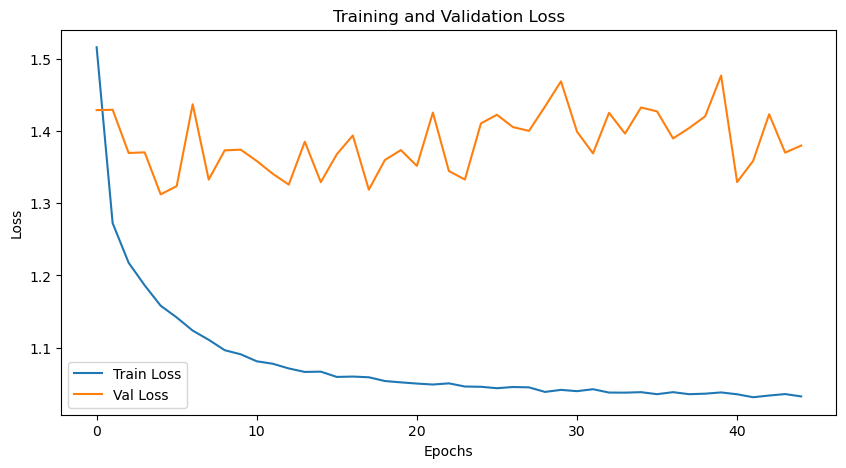

In [13]:
# Plotting training curves
plt.figure(figsize=(10, 5))
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

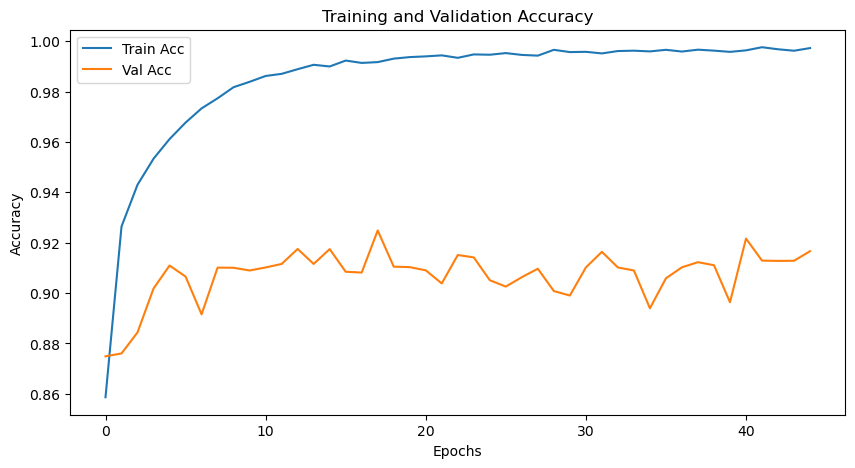

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(train_acc_list, label='Train Acc')
plt.plot(val_acc_list, label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [15]:
# Load best model
model.load_state_dict(torch.load('googlenet_best_model.pth'))

<All keys matched successfully>

In [16]:
# Testing
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Overall Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

Overall Accuracy: 0.9399
Precision: 0.9431
Recall: 0.9399
F1-score: 0.9377
